In [1]:
# NOTE: this is a custom cell that contains the common imports I personally 
# use these may/may not be necessary for the following examples

# DL framework
import tensorflow as tf

from datetime import datetime

# common packages
import numpy as np
import os # handling file i/o
import sys
import math
import time # timing epochs
import random

# for ordered dict when building layer components
import collections

# plotting pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import pyplot
from matplotlib import colors # making colors consistent
from mpl_toolkits.axes_grid1 import make_axes_locatable # colorbar helper


# from imageio import imread # read image from disk
# + data augmentation
from scipy import ndimage
from scipy import misc


import pickle # manually saving best params
from sklearn.utils import shuffle # shuffling data batches
from tqdm import tqdm # display training progress bar

# const
SEED = 42

# Helper to make the output consistent
def reset_graph(seed=SEED):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# helper to create dirs if they don't already exist
def maybe_create_dir(dir_path):
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)
        print("{} created".format(dir_path))
    else:
        print("{} already exists".format(dir_path))
    
def make_standard_dirs(saver=True, best_params=True, tf_logs=True):
    # `saver/` will hold tf saver files
    maybe_create_dir("lesion/saver")
    # `best_params/` will hold a serialized version of the best params
    # I like to keep this as a backup in case I run into issues with
    # the saver files
    maybe_create_dir("lesion/best_params")
    # `tf_logs/` will hold the logs that will be visable in tensorboard
    maybe_create_dir("lesion/tf_logs")

    
# set tf log level to supress messages, unless an error
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Important Version information
print("Python: {}".format(sys.version_info[:]))
print('TensorFlow: {}'.format(tf.__version__))

# Check if using GPU
if not tf.test.gpu_device_name():
    print('No GPU')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
    
reset_graph()

Python: (3, 5, 4, 'final', 0)
TensorFlow: 1.4.0
Default GPU Device: /device:GPU:0


In [2]:
make_standard_dirs()

lesion/saver already exists
lesion/best_params already exists
lesion/tf_logs already exists


In [5]:
BEST_PARAMS_PATH = "best_params_2"
FINAL_DIR = "../../dataset/record_holder/lesion"
for _, _, files in os.walk(FINAL_DIR):
    files = sorted(files)
    for filename in files:
        print(filename)

test.tfrecords
train.tfrecords
val.tfrecords


In [6]:
# these two functions (get_model_params and restore_model_params) are 
# ad[a|o]pted from; 
# https://github.com/ageron/handson-ml/blob/master/11_deep_learning.ipynb
def get_model_params():
    global_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)
    return {global_vars.op.name: value for global_vars, value in 
            zip(global_vars, tf.get_default_session().run(global_vars))}

def restore_model_params(model_params, g, sess):
    gvar_names = list(model_params.keys())
    assign_ops = {gvar_name: g.get_operation_by_name(gvar_name + "/Assign")
                  for gvar_name in gvar_names}
    init_values = {gvar_name: assign_op.inputs[1] for gvar_name, assign_op in assign_ops.items()}
    feed_dict = {init_values[gvar_name]: model_params[gvar_name] for gvar_name in gvar_names}
    sess.run(assign_ops, feed_dict=feed_dict)

# these two functions are used to manually save the best
# model params to disk
def save_obj(obj, name):
    with open('lesion/best_params/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name):
    with open('lesion/best_params/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

## Dataset

In [7]:
GLOBAL_SET_TYPE = None

def _parse_function(example_proto):
    global GLOBAL_SET_TYPE
    labelName = str(GLOBAL_SET_TYPE) + '/label'
    featureName = str(GLOBAL_SET_TYPE) + '/image'
    feature = {featureName: tf.FixedLenFeature([], tf.string),
               labelName: tf.FixedLenFeature([], tf.int64)}
    
    # decode
    parsed_features = tf.parse_single_example(example_proto, features=feature)
    
    # convert image data from string to number
    image = tf.decode_raw(parsed_features[featureName], tf.float32)
    image = tf.reshape(image, [224, 224, 3])
    label = tf.cast(parsed_features[labelName], tf.int64)
    
    # [do any preprocessing here]
    
    return image, label

In [8]:
def return_batched_iter(setType, data_params, sess):
    global GLOBAL_SET_TYPE
    global FINAL_DIR
    GLOBAL_SET_TYPE = setType
    
    filenames_ph = tf.placeholder(tf.string, shape=[None])

    dataset = tf.data.TFRecordDataset(filenames_ph)
    dataset = dataset.map(_parse_function)  # Parse the record into tensors.
    if GLOBAL_SET_TYPE != 'test':
        dataset = dataset.shuffle(buffer_size=data_params['buffer_size'])
    #dataset = dataset.shuffle(buffer_size=1)
    dataset = dataset.batch(data_params['batch_size'])
    dataset = dataset.repeat(1)
    
    iterator = dataset.make_initializable_iterator()
    
    tfrecords_file_name = str(GLOBAL_SET_TYPE) + '.tfrecords'
    tfrecord_file_path = os.path.join(FINAL_DIR, tfrecords_file_name)
    
    # initialize
    sess.run(iterator.initializer, feed_dict={filenames_ph: [tfrecord_file_path]})
    
    return iterator

In [9]:
def create_hyper_params():
    data_params = {}
    data_params['n_epochs'] = 100
    data_params['batch_size'] = 32
    data_params['buffer_size'] = 128 # for shuffling

    data_params['init_lr'] = 1e-5

    return data_params

In [10]:
def build_graph(data_params):
    g = tf.Graph()
    n_outputs = 1
    IMG_HEIGHT = 224
    IMG_WIDTH = 224
    CHANNELS = 3
    with g.as_default():
        with tf.name_scope("inputs"):
            X = tf.placeholder(tf.float32, shape=[None, IMG_HEIGHT, IMG_WIDTH, CHANNELS], name="X") # Input
            #y = tf.placeholder(tf.float32, shape=(None, n_outputs), name="labels") # Target
            y_raw = tf.placeholder(tf.int64, shape=[None, n_outputs], name="y_input")
            y = tf.cast(y_raw, tf.float32, name="label")

        with tf.name_scope("cnn"):
            #224x224x3
            h_1 = tf.layers.conv2d(X, filters=32, kernel_size=3, activation=tf.nn.elu,
                                   padding='SAME', strides=2, name="conv_1") # 112x112x3
            
            #112x112x32
            h_2 = tf.layers.conv2d(h_1, filters=64, kernel_size=3, activation=tf.nn.elu,
                                   padding='SAME', strides=2, name="conv_2") # 64x64x64
            
            #64x64x64
            h_3 = tf.layers.conv2d(h_2, filters=96, kernel_size=3, activation=tf.nn.elu,
                                   padding='SAME', strides=2, name="conv_3") # 32x32x96
            
            # 32x32x96
            h_4 = tf.layers.max_pooling2d(h_3, pool_size=[2,2],
                                          strides=2, name="max_pool_01") # 16x16x96
            
            # 16x16x96
            h_5 = tf.layers.conv2d(h_4, filters=128, kernel_size=3, activation=tf.nn.elu,
                                   padding='SAME', strides=1, name="conv_4") # 16x16x128
            
            # 16x16x128
            h_6 = tf.layers.conv2d(h_5, filters=192, kernel_size=3, activation=tf.nn.elu,
                                   padding='SAME', strides=1, name="conv_5") # 16x16x192
            
            # 16x16x192
            h_7 = tf.layers.max_pooling2d(h_6, pool_size=[2,2],
                                          strides=2, name="max_pool_02") # 8x8x192
            
            # 8x8x192
            h_8 = tf.layers.conv2d(h_7, filters=256, kernel_size=3, activation=tf.nn.elu,
                                   padding='SAME', strides=2, name="conv_6") # 4x4x256
            
            # 4x4x256
            h_9 = tf.layers.conv2d(h_8, filters=1024, kernel_size=4, activation=tf.nn.elu,
                                   padding='SAME', strides=1, name="conv_7") # 1x1x1024
            last_shape = int(np.prod(h_9.get_shape()[1:]))
            h_9_flat = tf.reshape(h_9, shape=[-1, last_shape]) # 1024
            
            # 1024
            h_10 = tf.layers.dense(h_9_flat, 256, name="layer_01", activation=tf.nn.elu)
            h_11 = tf.layers.dense(h_10, 64, name="layer_02", activation=tf.nn.elu)
            h_12 = tf.layers.dense(h_11, 16, name="layer_03", activation=tf.nn.elu)
            
            logits = tf.layers.dense(h_12, n_outputs, name="logits")
            preds = tf.sigmoid(logits, name="preds")

        with tf.name_scope("loss"):
            xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=logits)
            batch_loss = tf.reduce_mean(xentropy, name="loss")
        
        with tf.name_scope("train"):
            optimizer = tf.train.AdamOptimizer(learning_rate=data_params['init_lr'],
                                               beta1=0.9,
                                               beta2=0.999,
                                               epsilon=1e-08,
                                               use_locking=False,
                                               name='Adam')
            training_op = optimizer.minimize(batch_loss, name="training_op")
            
        with tf.name_scope("save_session"):
            init_global = tf.global_variables_initializer()
            init_local = tf.local_variables_initializer()
            saver = tf.train.Saver()

        # Ops: training metrics
        with tf.name_scope("metrics"):
            # ================================== performance
            with tf.name_scope("common"):
                #preds = tf.nn.softmax(logits, name="prediction")
                #y_true_cls = tf.argmax(y,1)
                #y_pred_cls = tf.argmax(preds,1)
                y_true_cls = tf.greater_equal(y, 0.5)
                y_pred_cls = tf.greater_equal(preds, 0.5)

                correct_prediction = tf.equal(y_pred_cls, y_true_cls, name="correct_predictions")
                batch_acc = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
            with tf.name_scope("train_metrics") as scope:
                train_auc, train_auc_update = tf.metrics.auc(labels=y, predictions=preds)
                train_acc, train_acc_update = tf.metrics.accuracy(labels=y_true_cls, predictions=y_pred_cls)
                train_acc_vars = tf.contrib.framework.get_variables(scope, collection=tf.GraphKeys.LOCAL_VARIABLES)
                train_met_reset_op = tf.variables_initializer(train_acc_vars, name="train_met_reset_op")
            with tf.name_scope("val_metrics") as scope:
                val_auc, val_auc_update = tf.metrics.auc(labels=y, predictions=preds)
                val_acc, val_acc_update = tf.metrics.accuracy(labels=y_true_cls, predictions=y_pred_cls)
                val_acc_vars = tf.contrib.framework.get_variables(scope, collection=tf.GraphKeys.LOCAL_VARIABLES)
                val_met_reset_op = tf.variables_initializer(val_acc_vars, name="val_met_reset_op")
            with tf.name_scope("test_metrics") as scope:
                test_auc, test_auc_update = tf.metrics.auc(labels=y, predictions=preds)
                test_acc, test_acc_update = tf.metrics.accuracy(labels=y_true_cls, predictions=y_pred_cls)
                test_acc_vars = tf.contrib.framework.get_variables(scope, collection=tf.GraphKeys.LOCAL_VARIABLES)
                test_acc_reset_op = tf.variables_initializer(test_acc_vars, name="test_met_reset_op")

            # =============================================== loss 
            with tf.name_scope("train_loss_eval") as scope:
                train_mean_loss, train_mean_loss_update = tf.metrics.mean(batch_loss)
                train_loss_vars = tf.contrib.framework.get_variables(scope, collection=tf.GraphKeys.LOCAL_VARIABLES)
                train_loss_reset_op = tf.variables_initializer(train_loss_vars, name="train_loss_reset_op")
            with tf.name_scope("val_loss_eval") as scope:
                val_mean_loss, val_mean_loss_update = tf.metrics.mean(batch_loss)
                val_loss_vars = tf.contrib.framework.get_variables(scope, collection=tf.GraphKeys.LOCAL_VARIABLES)
                val_loss_reset_op = tf.variables_initializer(val_loss_vars, name="val_loss_reset_op")
            with tf.name_scope("test_loss_eval")as scope:
                test_mean_loss, test_mean_loss_update = tf.metrics.mean(batch_loss)
                test_loss_vars = tf.contrib.framework.get_variables(scope, collection=tf.GraphKeys.LOCAL_VARIABLES)
                test_loss_reset_op = tf.variables_initializer(test_loss_vars, name="test_loss_rest_op")

        # --- create collections
        for node in (saver, init_global, init_local):
            g.add_to_collection("save_init", node)
        for node in (X, y_raw, training_op):
            g.add_to_collection("main_ops", node)
        for node in (preds, y_true_cls, y_pred_cls, correct_prediction):
            g.add_to_collection("preds", node)
        for node in (train_auc, train_auc_update, train_acc, train_acc_update, train_met_reset_op):
            g.add_to_collection("train_metrics", node)
        for node in (val_auc, val_auc_update, val_acc, val_acc_update, val_met_reset_op):
            g.add_to_collection("val_metrics", node)
        for node in (test_auc, test_auc_update, test_acc, test_acc_update, test_acc_reset_op):
            g.add_to_collection("test_metrics", node)
        for node in (train_mean_loss, train_mean_loss_update, train_loss_reset_op):
            g.add_to_collection("train_loss", node)
        for node in (val_mean_loss, val_mean_loss_update, val_loss_reset_op):
            g.add_to_collection("val_loss", node)
        for node in (test_mean_loss, test_mean_loss_update, test_loss_reset_op):
            g.add_to_collection("test_loss", node)
        g.add_to_collection("logits", logits)
            
        # ===================================== tensorboard
        with tf.name_scope("tensorboard_writer") as scope:
            epoch_train_loss_scalar = tf.summary.scalar('train_epoch_loss', train_mean_loss)
            epoch_train_acc_scalar = tf.summary.scalar('train_epoch_acc', train_acc)
            epoch_train_auc_scalar = tf.summary.scalar('train_epoch_auc', train_auc)
            epoch_train_write_op = tf.summary.merge([epoch_train_loss_scalar, epoch_train_acc_scalar, epoch_train_auc_scalar], name="epoch_train_write_op")

            # ===== epoch, validation
            epoch_validation_loss_scalar = tf.summary.scalar('validation_epoch_loss', val_mean_loss)
            epoch_validation_acc_scalar = tf.summary.scalar('validation_epoch_acc', val_acc)
            epoch_validation_auc_scalar = tf.summary.scalar('validation_epoch_auc', val_auc)
            epoch_validation_write_op = tf.summary.merge([epoch_validation_loss_scalar, epoch_validation_acc_scalar, epoch_validation_auc_scalar], name="epoch_validation_write_op")
        
        for node in (epoch_train_write_op, epoch_validation_write_op):
            g.add_to_collection("tensorboard", node)
            

    return g

In [11]:
def train_graph(g):
    global BEST_PARAMS_PATH
    saver, init_global, init_local = g.get_collection("save_init")
    X, y_raw, training_op = g.get_collection("main_ops")
    preds, y_true_cls, y_pred_cls, _ = g.get_collection("preds")
    train_auc, train_auc_update, train_acc, train_acc_update, train_met_reset_op = g.get_collection("train_metrics")
    val_auc, val_auc_update, val_acc, val_acc_update, val_met_reset_op = g.get_collection("val_metrics")
    train_mean_loss, train_mean_loss_update, train_loss_reset_op = g.get_collection("train_loss")
    val_mean_loss, val_mean_loss_update, val_loss_reset_op = g.get_collection("val_loss")
    epoch_train_write_op, epoch_validation_write_op = g.get_collection("tensorboard")
#     next_tr_element, next_val_element, _ = g.get_collection("data_sets")

    train_writer = tf.summary.FileWriter(os.path.join("tf_logs","train"))
    val_writer = tf.summary.FileWriter(os.path.join("tf_logs","validation"))
    
    best_val_loss = np.inf
    
    with tf.Session(graph=g) as sess:

        # test
#         test_iter = return_batched_iter('test', data_params, sess)
#         next_test_element = test_iter.get_next()
        sess.run([init_global, init_local])
        
        for e in tqdm(range(1,data_params['n_epochs']+1)):
            sess.run([val_met_reset_op,val_loss_reset_op,train_met_reset_op,train_loss_reset_op])
            # training
            tr_iter = return_batched_iter('train', data_params, sess)
            next_tr_element = tr_iter.get_next()
            
            # loop entire training set
            while True:
                try:
                    data, target = sess.run(next_tr_element)
                    target = np.reshape(target, (target.shape[0], 1))
                    sess.run([training_op, train_auc_update, train_acc_update, train_mean_loss_update], 
                             feed_dict={X:data, y_raw:target})
#                     pr, yt, yp = sess.run([preds, y_true_cls, y_pred_cls], feed_dict={X:data, y_raw:target})
#                     print(pr)
#                     print(yt)
#                     print(yp)
                except tf.errors.OutOfRangeError:
                    break
        
            # write average for epoch
            summary = sess.run(epoch_train_write_op)    
            train_writer.add_summary(summary, e)
            train_writer.flush()

            # run validation
            # validation
            val_iter = return_batched_iter('val', data_params, sess)
            next_val_element = val_iter.get_next()
            while True:
                try:
                    Xb, yb = sess.run(next_val_element)
                    yb = np.reshape(yb, (yb.shape[0], 1))
                    sess.run([val_auc_update, val_acc_update, val_mean_loss_update], feed_dict={X:Xb, y_raw:yb})
                except tf.errors.OutOfRangeError:
                    break

            # check for (and save) best validation params here
            cur_loss, cur_acc = sess.run([val_mean_loss, val_acc])
            if cur_loss < best_val_loss:
                best_val_loss = cur_loss
                best_params = get_model_params()
                save_obj(best_params, BEST_PARAMS_PATH)
                print("best params saved: val acc: {:.3f}% val loss: {:.4f}".format(cur_acc*100, cur_loss))

            summary = sess.run(epoch_validation_write_op) 
            val_writer.add_summary(summary, e)
            val_writer.flush()
        
        train_writer.close()
        val_writer.close()
    return sess

In [12]:
reset_graph()
data_params = create_hyper_params()
g = build_graph(data_params)
sess = train_graph(g)

  1%|          | 1/100 [00:04<07:03,  4.28s/it]

best params saved: val acc: 58.687% val loss: 0.6718


  3%|▎         | 3/100 [00:09<05:20,  3.31s/it]

best params saved: val acc: 57.915% val loss: 0.6664


  4%|▍         | 4/100 [00:12<05:09,  3.22s/it]

best params saved: val acc: 53.668% val loss: 0.6585


  5%|▌         | 5/100 [00:15<05:03,  3.20s/it]

best params saved: val acc: 57.529% val loss: 0.6462


  9%|▉         | 9/100 [00:27<04:33,  3.00s/it]

best params saved: val acc: 62.934% val loss: 0.6263


 12%|█▏        | 12/100 [00:35<04:21,  2.97s/it]

best params saved: val acc: 61.776% val loss: 0.6200


 13%|█▎        | 13/100 [00:38<04:18,  2.98s/it]

best params saved: val acc: 60.618% val loss: 0.6138


100%|██████████| 100/100 [04:44<00:00,  2.85s/it]


## Test
This is a checkpoint - in that training can be skipped if previous best params are saved

In [13]:
reset_graph()
data_params = create_hyper_params()
g2 = build_graph(data_params)
best_params = load_obj(BEST_PARAMS_PATH)
with tf.Session(graph=g2) as sess:
    saver, init_global, init_local = g2.get_collection("save_init")
    X, y_raw, training_op = g2.get_collection("main_ops")
    preds, y_true_cls, y_pred_cls, _ = g2.get_collection("preds")
    test_auc, test_auc_update, test_acc, test_acc_update, test_acc_reset_op = g2.get_collection("test_metrics")
    test_mean_loss, test_mean_loss_update, test_loss_reset_op = g2.get_collection("test_loss")
    
    restore_model_params(model_params=best_params, g=g2, sess=sess)
    sess.run([test_acc_reset_op, test_loss_reset_op])
    
    test_iter = return_batched_iter('test', data_params, sess)
    next_test_element = test_iter.get_next()
    while True:
        try:
            Xb, yb = sess.run(next_test_element)
            yb = np.reshape(yb, (yb.shape[0], 1))
            sess.run([test_auc_update, test_acc_update, test_mean_loss_update], feed_dict={X:Xb, y_raw:yb})
        except tf.errors.OutOfRangeError:
            break    
    
    # print
    final_test_acc, final_test_loss, final_test_auc = sess.run([test_acc, test_mean_loss, test_auc])
    print("test auc: {:.3f}% acc: {:.3f}% loss: {:.5f}".format(final_test_auc*100, 
                                                              final_test_acc*100,
                                                              final_test_loss))

test auc: 67.790% acc: 62.257% loss: 0.60613


## Obtain Sample Image


In [45]:
reset_graph()
data_params = create_hyper_params()
g2 = build_graph(data_params)
best_params = load_obj(BEST_PARAMS_PATH)
with tf.Session(graph=g2) as sess:
    saver, init_global, init_local = g2.get_collection("save_init")
    X, y_raw, training_op = g2.get_collection("main_ops")
    preds, y_true_cls, y_pred_cls, correct_prediction = g2.get_collection("preds")
    test_auc, test_auc_update, test_acc, test_acc_update, test_acc_reset_op = g2.get_collection("test_metrics")
    test_mean_loss, test_mean_loss_update, test_loss_reset_op = g2.get_collection("test_loss")
    
    restore_model_params(model_params=best_params, g=g2, sess=sess)
    sess.run([test_acc_reset_op, test_loss_reset_op])
    
    test_iter = return_batched_iter('test', data_params, sess)
    next_test_element = test_iter.get_next()
    
    # use to get best prediction
    best_pred = 100
    the_image = None
    the_pred = None
    cor_label = None
    while True:
        try:
            Xb, yb = sess.run(next_test_element)
            yb = np.reshape(yb, (yb.shape[0], 1))
            #sess.run([test_auc_update, test_acc_update, test_mean_loss_update], feed_dict={X:Xb, y_raw:yb})
            pred, y_tr, y_pr, correct = sess.run([preds, y_true_cls, y_pred_cls, correct_prediction], 
                                                 feed_dict={X:Xb, y_raw:yb})
            # loop return
            for i, state in enumerate(correct):
                if state:
                    cur_pred = pred[i]
                    if cur_pred < best_pred and cur_pred > 0:
                        print("best pred: {:.3f}%".format(cur_pred[0]*100))
                        best_pred = cur_pred
                        the_image = Xb[i]
                        the_pred = y_pr[i]
                        cor_label = y_tr[i]     
        except tf.errors.OutOfRangeError:
            break


best pred: 21.950%
best pred: 21.432%
best pred: 16.699%
best pred: 13.556%


In [46]:
if the_pred[0]:
    pred_mb = "M"
else:
    pred_mb = "B"

if cor_label[0]:
    cor_mb = "M"
else:
    cor_mb = "B"

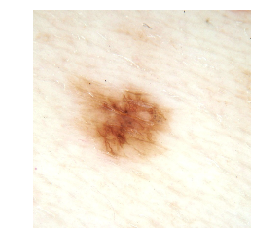


gt: B, pred: B, confidence: 86.444%
min:21.571441650390625, max:255.0


In [50]:
plt.imshow(the_image.astype(np.uint8), interpolation="nearest")
plt.axis("off")
plt.show()

if not the_pred[0]:
    pred_conf = "{:.3f}".format(100 - best_pred[0]*100)
else:
    pred_conf = "{:.3f}".format(best_pred[0]*100)
    
print()
print("gt: {}, pred: {}, confidence: {}%".format(cor_mb, pred_mb, pred_conf))
print("min:{}, max:{}".format(np.min(the_image), np.max(the_image)))

img_name = "./output_images/" + "pred_" + pred_mb + "_gt_" + cor_mb + "_c_" + pred_conf + ".png"
misc.imsave(img_name, the_image)

Malignant:
	grnd_truth: False
	pred_class: False


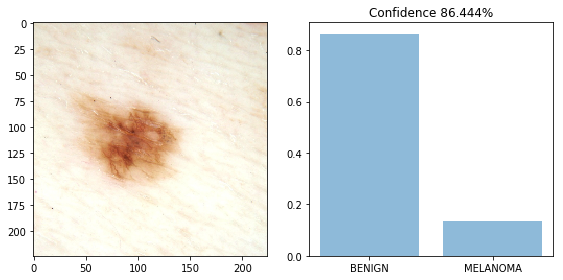

In [51]:
def display_figure_and_prob(img, conf, pred_malignant, gt_label, adv_bool=False):
    probs = [0, 0]
    y_pos = ['BENIGN', 'MELANOMA']
    probs[1] = conf
    probs[0] = 1-conf
    max_conf = max(probs[0], probs[1])

    
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
    ax1.imshow(img.astype(np.uint8), interpolation="nearest")
    #y_pos = np.arange(2)
    print("Malignant:\n\tgrnd_truth: {}\n\tpred_class: {}".format(gt_label, pred_malignant))
    ax2.bar(y_pos, probs, align='center', alpha=0.5)
    plt.title("Confidence {:.3f}%".format(max_conf*100))
    plt.grid('off')
    plt.tight_layout()
    
    if pred_malignant:
        pred_mb = "M"
    else:
        pred_mb = "B"

    if gt_label:
        cor_mb = "M"
    else:
        cor_mb = "B"
        

    img_name = "./output_images/" + "img_and_conf_pred_" + pred_mb + "_gt_" + cor_mb
    if adv_bool:
        img_name += "_adv"
    img_name += ".png"
    plt.savefig(img_name, bbox_inches='tight', pad_inches=0, frameon=False)
    plt.show()
display_figure_and_prob(the_image, best_pred[0], the_pred[0], cor_label[0])

## How does the current architecture classify the image

In [52]:
def test_model(img, label):
    reset_graph()
    data_params = create_hyper_params()
    g2 = build_graph(data_params)
    best_params = load_obj(BEST_PARAMS_PATH)
    with tf.Session(graph=g2) as sess:
        saver, init_global, init_local = g2.get_collection("save_init")
        X, y_raw, training_op = g2.get_collection("main_ops")
        preds, y_true_cls, y_pred_cls, _ = g2.get_collection("preds")
        test_auc, test_auc_update, test_acc, test_acc_update, test_acc_reset_op = g2.get_collection("test_metrics")
        test_mean_loss, test_mean_loss_update, test_loss_reset_op = g2.get_collection("test_loss")
        logz = g2.get_collection("logits")[0]

        sess.run([init_global, init_local])

        restore_model_params(model_params=best_params, g=g2, sess=sess)
        sess.run([test_acc_reset_op, test_loss_reset_op])
        Xb, yb = np.expand_dims(img,0), np.expand_dims(label, 0)
        batch_accuracy, batch_loss, batch_auc = sess.run([test_acc_update, test_mean_loss_update, test_auc_update], 
                                                                  feed_dict={X:Xb,y_raw:[yb]})
        pred_value, true_cls_value, pred_cls_value = sess.run([preds, y_true_cls, y_pred_cls],
                                                              feed_dict={X:Xb,y_raw:[yb]})
        logits_val = sess.run([logz], feed_dict={X:Xb,y_raw:[yb]})[0]
        print
        final_test_acc, final_test_loss, final_test_auc = sess.run([test_acc, test_mean_loss, test_auc])
        print("test auc: {:.3f}% acc: {:.3f}% loss: {:.5f}".format(final_test_auc*100, 
                                                                   final_test_acc*100,
                                                                   final_test_loss))
        pred_idx = pred_cls_value[0]
        print("true_class: {}\npred_class {}".format(true_cls_value, pred_cls_value))
        
        #print(pred_value[0])
        #print(pred_idx)
        confidence = pred_value[0][0]*100
        #print("confidence: {:.4f}%".format(confidence[0]))

        #display_figure_and_prob(img=img, conf=pred_value[0][pred_idx][0], pred_malignant=pred_cls_value[0][0], gt_label=label)
        
    return pred_idx, confidence
        
pred_label, pred_confidence = test_model(the_image, cor_label[0])

test auc: 100.000% acc: 100.000% loss: 0.14567
true_class: [[False]]
pred_class [[False]]


In [53]:
def build_adv_graph(data_params):
    g = tf.Graph()
    n_outputs = 1
    IMG_HEIGHT = 224
    IMG_WIDTH = 224
    CHANNELS = 3
    with g.as_default():
        with tf.name_scope("inputs"):
            X = tf.placeholder(tf.float32, shape=[None, IMG_HEIGHT, IMG_WIDTH, CHANNELS], name="X") # Input
            Xx = tf.Variable(tf.zeros((IMG_HEIGHT, IMG_WIDTH, CHANNELS)))
            Xxx = tf.expand_dims(Xx, 0)
            #y = tf.placeholder(tf.float32, shape=(None, n_outputs), name="labels") # Target
            y_raw = tf.placeholder(tf.int64, shape=[None, n_outputs], name="y_input")
            y = tf.cast(y_raw, tf.float32, name="label")

        with tf.name_scope("cnn"):
            #224x224x3
            h_1 = tf.layers.conv2d(Xxx, filters=32, kernel_size=3, activation=tf.nn.elu,
                                   padding='SAME', strides=2, name="conv_1") # 112x112x3
            
            #112x112x32
            h_2 = tf.layers.conv2d(h_1, filters=64, kernel_size=3, activation=tf.nn.elu,
                                   padding='SAME', strides=2, name="conv_2") # 64x64x64
            
            #64x64x64
            h_3 = tf.layers.conv2d(h_2, filters=96, kernel_size=3, activation=tf.nn.elu,
                                   padding='SAME', strides=2, name="conv_3") # 32x32x96
            
            # 32x32x96
            h_4 = tf.layers.max_pooling2d(h_3, pool_size=[2,2],
                                          strides=2, name="max_pool_01") # 16x16x96
            
            # 16x16x96
            h_5 = tf.layers.conv2d(h_4, filters=128, kernel_size=3, activation=tf.nn.elu,
                                   padding='SAME', strides=1, name="conv_4") # 16x16x128
            
            # 16x16x128
            h_6 = tf.layers.conv2d(h_5, filters=192, kernel_size=3, activation=tf.nn.elu,
                                   padding='SAME', strides=1, name="conv_5") # 16x16x192
            
            # 16x16x192
            h_7 = tf.layers.max_pooling2d(h_6, pool_size=[2,2],
                                          strides=2, name="max_pool_02") # 8x8x192
            
            # 8x8x192
            h_8 = tf.layers.conv2d(h_7, filters=256, kernel_size=3, activation=tf.nn.elu,
                                   padding='SAME', strides=2, name="conv_6") # 4x4x256
            
            # 4x4x256
            h_9 = tf.layers.conv2d(h_8, filters=1024, kernel_size=4, activation=tf.nn.elu,
                                   padding='SAME', strides=1, name="conv_7") # 1x1x1024
            last_shape = int(np.prod(h_9.get_shape()[1:]))
            h_9_flat = tf.reshape(h_9, shape=[-1, last_shape]) # 1024
            
            # 1024
            h_10 = tf.layers.dense(h_9_flat, 256, name="layer_01", activation=tf.nn.elu)
            h_11 = tf.layers.dense(h_10, 64, name="layer_02", activation=tf.nn.elu)
            h_12 = tf.layers.dense(h_11, 16, name="layer_03", activation=tf.nn.elu)
            
            logits = tf.layers.dense(h_12, n_outputs, name="logits")
            preds = tf.sigmoid(logits, name="preds")

        with tf.name_scope("loss"):
            xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=logits)
            batch_loss = tf.reduce_mean(xentropy, name="loss")
        
        with tf.name_scope("train"):
            optimizer = tf.train.AdamOptimizer(learning_rate=data_params['init_lr'],
                                               beta1=0.9,
                                               beta2=0.999,
                                               epsilon=1e-08,
                                               use_locking=False,
                                               name='Adam')
            training_op = optimizer.minimize(batch_loss, name="training_op")
            
        with tf.name_scope("save_session"):
            init_global = tf.global_variables_initializer()
            init_local = tf.local_variables_initializer()
            saver = tf.train.Saver()
            
            
        with tf.name_scope("adv"):
            x = tf.placeholder(tf.float32, (IMG_HEIGHT, IMG_WIDTH, CHANNELS), name="jack") # Input
            x_hat = Xx
            assign_op = tf.assign(x_hat, x)

            y_hat = tf.placeholder(tf.int32, (None))
            labels = tf.cast(y_hat, tf.float32, name="label")
            #labels = tf.one_hot(y_hat, 10)
            #print("logits: {}".format(logits))
            #print("labels: {}".format(labels))
            loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=labels, name="adv_loss")
            adv_batch_loss = tf.reduce_mean(loss)
#             optimizerz = tf.train.AdamOptimizer(learning_rate=1e-3,
#                                                beta1=0.9,
#                                                beta2=0.999,
#                                                epsilon=1e-08,
#                                                use_locking=False,
#                                                name='Adam')
#             optim_step = optimizerz.minimize(adv_batch_loss, var_list=[Xx])
            optim_step = tf.train.GradientDescentOptimizer(3).minimize(adv_batch_loss, var_list=[Xx])
            
            epsilon = tf.placeholder(tf.float32, ())
            below = x - epsilon
            above = x + epsilon
            projected = tf.clip_by_value(tf.clip_by_value(x_hat, below, above), 0, 255)

            with tf.control_dependencies([projected]):
                project_step = tf.assign(x_hat, projected)
                
            for node in (assign_op, x, optim_step, loss, y_hat, epsilon, x_hat, project_step):
                g.add_to_collection("adv", node)

        # Ops: training metrics
        with tf.name_scope("metrics"):
            # ================================== performance
            with tf.name_scope("common"):
                #preds = tf.nn.softmax(logits, name="prediction")
                #y_true_cls = tf.argmax(y,1)
                #y_pred_cls = tf.argmax(preds,1)
                y_true_cls = tf.greater_equal(y, 0.5)
                y_pred_cls = tf.greater_equal(preds, 0.5)

                correct_prediction = tf.equal(y_pred_cls, y_true_cls, name="correct_predictions")
                batch_acc = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
            with tf.name_scope("train_metrics") as scope:
                train_auc, train_auc_update = tf.metrics.auc(labels=y, predictions=preds)
                train_acc, train_acc_update = tf.metrics.accuracy(labels=y_true_cls, predictions=y_pred_cls)
                train_acc_vars = tf.contrib.framework.get_variables(scope, collection=tf.GraphKeys.LOCAL_VARIABLES)
                train_met_reset_op = tf.variables_initializer(train_acc_vars, name="train_met_reset_op")
            with tf.name_scope("val_metrics") as scope:
                val_auc, val_auc_update = tf.metrics.auc(labels=y, predictions=preds)
                val_acc, val_acc_update = tf.metrics.accuracy(labels=y_true_cls, predictions=y_pred_cls)
                val_acc_vars = tf.contrib.framework.get_variables(scope, collection=tf.GraphKeys.LOCAL_VARIABLES)
                val_met_reset_op = tf.variables_initializer(val_acc_vars, name="val_met_reset_op")
            with tf.name_scope("test_metrics") as scope:
                test_auc, test_auc_update = tf.metrics.auc(labels=y, predictions=preds)
                test_acc, test_acc_update = tf.metrics.accuracy(labels=y_true_cls, predictions=y_pred_cls)
                test_acc_vars = tf.contrib.framework.get_variables(scope, collection=tf.GraphKeys.LOCAL_VARIABLES)
                test_acc_reset_op = tf.variables_initializer(test_acc_vars, name="test_met_reset_op")

            # =============================================== loss 
            with tf.name_scope("train_loss_eval") as scope:
                train_mean_loss, train_mean_loss_update = tf.metrics.mean(batch_loss)
                train_loss_vars = tf.contrib.framework.get_variables(scope, collection=tf.GraphKeys.LOCAL_VARIABLES)
                train_loss_reset_op = tf.variables_initializer(train_loss_vars, name="train_loss_reset_op")
            with tf.name_scope("val_loss_eval") as scope:
                val_mean_loss, val_mean_loss_update = tf.metrics.mean(batch_loss)
                val_loss_vars = tf.contrib.framework.get_variables(scope, collection=tf.GraphKeys.LOCAL_VARIABLES)
                val_loss_reset_op = tf.variables_initializer(val_loss_vars, name="val_loss_reset_op")
            with tf.name_scope("test_loss_eval")as scope:
                test_mean_loss, test_mean_loss_update = tf.metrics.mean(batch_loss)
                test_loss_vars = tf.contrib.framework.get_variables(scope, collection=tf.GraphKeys.LOCAL_VARIABLES)
                test_loss_reset_op = tf.variables_initializer(test_loss_vars, name="test_loss_rest_op")

        # --- create collections
        for node in (saver, init_global, init_local):
            g.add_to_collection("save_init", node)
        for node in (X, Xx, y, training_op):
            g.add_to_collection("main_ops", node)
        for node in (preds, y_true_cls, y_pred_cls, correct_prediction):
            g.add_to_collection("preds", node)
        for node in (train_auc, train_auc_update, train_acc, train_acc_update, train_met_reset_op):
            g.add_to_collection("train_metrics", node)
        for node in (val_auc, val_auc_update, val_acc, val_acc_update, val_met_reset_op):
            g.add_to_collection("val_metrics", node)
        for node in (test_auc, test_auc_update, test_acc, test_acc_update, test_acc_reset_op):
            g.add_to_collection("test_metrics", node)
        for node in (train_mean_loss, train_mean_loss_update, train_loss_reset_op):
            g.add_to_collection("train_loss", node)
        for node in (val_mean_loss, val_mean_loss_update, val_loss_reset_op):
            g.add_to_collection("val_loss", node)
        for node in (test_mean_loss, test_mean_loss_update, test_loss_reset_op):
            g.add_to_collection("test_loss", node)
        g.add_to_collection("logits", logits)
            
        # ===================================== tensorboard
        with tf.name_scope("tensorboard_writer") as scope:
            epoch_train_loss_scalar = tf.summary.scalar('train_epoch_loss', train_mean_loss)
            epoch_train_acc_scalar = tf.summary.scalar('train_epoch_acc', train_acc)
            epoch_train_auc_scalar = tf.summary.scalar('train_epoch_auc', train_auc)
            epoch_train_write_op = tf.summary.merge([epoch_train_loss_scalar, epoch_train_acc_scalar, epoch_train_auc_scalar], name="epoch_train_write_op")

            # ===== epoch, validation
            epoch_validation_loss_scalar = tf.summary.scalar('validation_epoch_loss', val_mean_loss)
            epoch_validation_acc_scalar = tf.summary.scalar('validation_epoch_acc', val_acc)
            epoch_validation_auc_scalar = tf.summary.scalar('validation_epoch_auc', val_auc)
            epoch_validation_write_op = tf.summary.merge([epoch_validation_loss_scalar, epoch_validation_acc_scalar, epoch_validation_auc_scalar], name="epoch_validation_write_op")
        
        for node in (epoch_train_write_op, epoch_validation_write_op):
            g.add_to_collection("tensorboard", node)
            
    return g

In [54]:
def produce_targeted_adv_image(img, adv_target=1, adv_eps=20, adv_lr=1e-1,adv_steps=80000):
    #img = (np.asarray(img) / 255.0).astype(np.float32)
    #TODO: learning rate is currently hardcoded
    reset_graph()
    data_params = create_hyper_params()
    g3 = build_adv_graph(data_params)
    best_params = load_obj(BEST_PARAMS_PATH)
    with tf.Session(graph=g3) as sess:
        saver, init_global, init_local = g3.get_collection("save_init")
        X, Xx, y, training_op = g3.get_collection("main_ops")
        preds, y_true_cls, y_pred_cls, _ = g3.get_collection("preds")
        test_auc, test_auc_update, test_acc, test_acc_update, test_acc_reset_op = g3.get_collection("test_metrics")
        test_mean_loss, test_mean_loss_update, test_loss_reset_op = g3.get_collection("test_loss")
        logz = g3.get_collection("logits")[0]

        sess.run([init_global, init_local])

        restore_model_params(model_params=best_params, g=g3, sess=sess)
        sess.run([test_acc_reset_op, test_loss_reset_op])
        

        # execution
        assign_op, x, optim_step, loss, y_hat, epsilon, x_hat, project_step = g3.get_collection("adv")

        # initialization step
        sess.run(assign_op, feed_dict={x: img})

        #print("adv_target: {}".format(adv_target.shape))
        # projected gradient descent
        #adv_target = np.expand_dims(adv_steps, 0)
        for i in tqdm(range(1, adv_steps+1)):
            # gradient descent step
            _, loss_value = sess.run(
                [optim_step, loss],
                feed_dict={y_hat: [adv_target]})
            # project step
            sess.run(project_step, feed_dict={x: img, epsilon: adv_eps})
            if (i+1) % 1000 == 0:
                print('step %d, loss=%g' % (i+1, loss_value))

        adv_out = x_hat.eval() # retrieve the adversarial example
        
    return adv_out
#the_image, best_pred[0], the_pred[0], cor_label[0]
adv_out = produce_targeted_adv_image(the_image, adv_target=1)
#adv_flat = adv_out.reshape((784))

  1%|▏         | 1008/80000 [00:11<14:41, 89.66it/s]

step 1000, loss=1.87077


  3%|▎         | 2014/80000 [00:22<14:32, 89.41it/s]

step 2000, loss=1.75474


  4%|▍         | 3014/80000 [00:33<14:05, 91.00it/s]

step 3000, loss=1.64999


  5%|▌         | 4013/80000 [00:43<13:46, 91.93it/s]

step 4000, loss=1.55408


  6%|▋         | 5014/80000 [00:54<13:29, 92.65it/s]

step 5000, loss=1.46692


  8%|▊         | 6008/80000 [01:04<13:15, 93.01it/s]

step 6000, loss=1.38706


  9%|▉         | 7016/80000 [01:15<13:03, 93.15it/s]

step 7000, loss=1.31418


 10%|█         | 8012/80000 [01:25<12:51, 93.35it/s]

step 8000, loss=1.24689


 11%|█▏        | 9013/80000 [01:36<12:38, 93.61it/s]

step 9000, loss=1.18422


 13%|█▎        | 10009/80000 [01:46<12:26, 93.78it/s]

step 10000, loss=1.12606


 14%|█▍        | 11011/80000 [01:57<12:14, 93.88it/s]

step 11000, loss=1.07178


 15%|█▌        | 12011/80000 [02:07<12:03, 93.92it/s]

step 12000, loss=1.02139


 16%|█▋        | 13013/80000 [02:18<11:52, 93.98it/s]

step 13000, loss=0.974528


 18%|█▊        | 14017/80000 [02:29<11:41, 94.05it/s]

step 14000, loss=0.930769


 19%|█▉        | 15009/80000 [02:39<11:30, 94.07it/s]

step 15000, loss=0.889797


 20%|██        | 16007/80000 [02:50<11:19, 94.16it/s]

step 16000, loss=0.851476


 21%|██▏       | 17009/80000 [03:00<11:09, 94.09it/s]

step 17000, loss=0.815754


 23%|██▎       | 18018/80000 [03:11<10:59, 93.98it/s]

step 18000, loss=0.782259


 24%|██▍       | 19019/80000 [03:22<10:48, 93.99it/s]

step 19000, loss=0.750758


 25%|██▌       | 20015/80000 [03:33<10:38, 93.95it/s]

step 20000, loss=0.721054


 26%|██▋       | 21008/80000 [03:43<10:27, 94.01it/s]

step 21000, loss=0.693033


 28%|██▊       | 22009/80000 [03:54<10:16, 94.00it/s]

step 22000, loss=0.666655


 29%|██▉       | 23011/80000 [04:04<10:06, 94.04it/s]

step 23000, loss=0.641713


 30%|███       | 24010/80000 [04:15<09:54, 94.15it/s]

step 24000, loss=0.618081


 31%|███▏      | 25012/80000 [04:25<09:43, 94.26it/s]

step 25000, loss=0.59573


 33%|███▎      | 26009/80000 [04:35<09:32, 94.35it/s]

step 26000, loss=0.574442


 34%|███▍      | 27019/80000 [04:46<09:21, 94.38it/s]

step 27000, loss=0.554178


 35%|███▌      | 28008/80000 [04:56<09:10, 94.41it/s]

step 28000, loss=0.534971


 36%|███▋      | 29011/80000 [05:07<08:59, 94.47it/s]

step 29000, loss=0.516771


 38%|███▊      | 30009/80000 [05:17<08:49, 94.48it/s]

step 30000, loss=0.4995


 39%|███▉      | 31013/80000 [05:28<08:38, 94.51it/s]

step 31000, loss=0.483046


 40%|████      | 32013/80000 [05:38<08:27, 94.53it/s]

step 32000, loss=0.467603


 41%|████▏     | 33010/80000 [05:49<08:17, 94.47it/s]

step 33000, loss=0.453053


 43%|████▎     | 34007/80000 [05:59<08:06, 94.47it/s]

step 34000, loss=0.439325


 44%|████▍     | 35013/80000 [06:10<07:55, 94.51it/s]

step 35000, loss=0.426329


 45%|████▌     | 36010/80000 [06:21<07:46, 94.35it/s]

step 36000, loss=0.414034


 46%|████▋     | 37012/80000 [06:32<07:35, 94.33it/s]

step 37000, loss=0.402384


 48%|████▊     | 38013/80000 [06:42<07:25, 94.33it/s]

step 38000, loss=0.391293


 49%|████▉     | 39010/80000 [06:53<07:14, 94.25it/s]

step 39000, loss=0.38075


 50%|█████     | 40014/80000 [07:04<07:04, 94.22it/s]

step 40000, loss=0.370726


 51%|█████▏    | 41018/80000 [07:15<06:53, 94.18it/s]

step 41000, loss=0.361204


 53%|█████▎    | 42009/80000 [07:26<06:43, 94.10it/s]

step 42000, loss=0.352133


 54%|█████▍    | 43012/80000 [07:36<06:32, 94.16it/s]

step 43000, loss=0.343491


 55%|█████▌    | 44017/80000 [07:47<06:22, 94.18it/s]

step 44000, loss=0.335225


 56%|█████▋    | 45008/80000 [07:57<06:11, 94.19it/s]

step 45000, loss=0.327349


 58%|█████▊    | 46009/80000 [08:08<06:01, 94.15it/s]

step 46000, loss=0.319817


 59%|█████▉    | 47014/80000 [08:20<05:51, 93.90it/s]

step 47000, loss=0.312614


 60%|██████    | 48013/80000 [08:31<05:40, 93.86it/s]

step 48000, loss=0.305715


 61%|██████▏   | 49015/80000 [08:41<05:29, 93.90it/s]

step 49000, loss=0.299118


 63%|██████▎   | 50014/80000 [08:52<05:19, 93.95it/s]

step 50000, loss=0.292806


 64%|██████▍   | 51015/80000 [09:02<05:08, 93.99it/s]

step 51000, loss=0.286748


 65%|██████▌   | 52006/80000 [09:13<04:57, 94.02it/s]

step 52000, loss=0.280941


 66%|██████▋   | 53007/80000 [09:24<04:47, 93.94it/s]

step 53000, loss=0.275371


 68%|██████▊   | 54013/80000 [09:34<04:36, 93.96it/s]

step 54000, loss=0.270012


 69%|██████▉   | 55011/80000 [09:45<04:25, 94.03it/s]

step 55000, loss=0.264856


 70%|███████   | 56011/80000 [09:55<04:15, 94.02it/s]

step 56000, loss=0.25989


 71%|███████▏  | 57008/80000 [10:07<04:04, 93.86it/s]

step 57000, loss=0.255108


 73%|███████▎  | 58015/80000 [10:17<03:54, 93.88it/s]

step 58000, loss=0.250512


 74%|███████▍  | 59013/80000 [10:28<03:43, 93.90it/s]

step 59000, loss=0.246083


 75%|███████▌  | 60012/80000 [10:38<03:32, 93.92it/s]

step 60000, loss=0.24181


 76%|███████▋  | 61013/80000 [10:49<03:22, 93.97it/s]

step 61000, loss=0.237677


 78%|███████▊  | 62017/80000 [10:59<03:11, 94.01it/s]

step 62000, loss=0.233683


 79%|███████▉  | 63013/80000 [11:10<03:00, 94.00it/s]

step 63000, loss=0.229815


 80%|████████  | 64012/80000 [11:20<02:50, 94.03it/s]

step 64000, loss=0.226064


 81%|████████▏ | 65012/80000 [11:31<02:39, 94.05it/s]

step 65000, loss=0.222418


 83%|████████▎ | 66011/80000 [11:41<02:28, 94.07it/s]

step 66000, loss=0.218889


 84%|████████▍ | 67011/80000 [11:52<02:18, 94.11it/s]

step 67000, loss=0.215473


 85%|████████▌ | 68009/80000 [12:02<02:07, 94.10it/s]

step 68000, loss=0.21217


 86%|████████▋ | 69012/80000 [12:14<01:56, 93.92it/s]

step 69000, loss=0.208973


 88%|████████▊ | 70010/80000 [12:25<01:46, 93.91it/s]

step 70000, loss=0.205874


 89%|████████▉ | 71013/80000 [12:36<01:35, 93.91it/s]

step 71000, loss=0.202872


 90%|█████████ | 72007/80000 [12:46<01:25, 93.91it/s]

step 72000, loss=0.199961


 91%|█████████▏| 73014/80000 [12:57<01:14, 93.94it/s]

step 73000, loss=0.197134


 93%|█████████▎| 74017/80000 [13:07<01:03, 93.95it/s]

step 74000, loss=0.194386


 94%|█████████▍| 75015/80000 [13:18<00:53, 93.96it/s]

step 75000, loss=0.19172


 95%|█████████▌| 76012/80000 [13:28<00:42, 93.99it/s]

step 76000, loss=0.189124


 96%|█████████▋| 77013/80000 [13:39<00:31, 94.02it/s]

step 77000, loss=0.186602


 98%|█████████▊| 78014/80000 [13:49<00:21, 94.04it/s]

step 78000, loss=0.184154


 99%|█████████▉| 79010/80000 [14:00<00:10, 94.06it/s]

step 79000, loss=0.181774


100%|██████████| 80000/80000 [14:10<00:00, 94.08it/s]


step 80000, loss=0.179463


test auc: 100.000% acc: 0.000% loss: 1.80620
true_class: [[False]]
pred_class [[ True]]
Malignant:
	grnd_truth: False
	pred_class: True


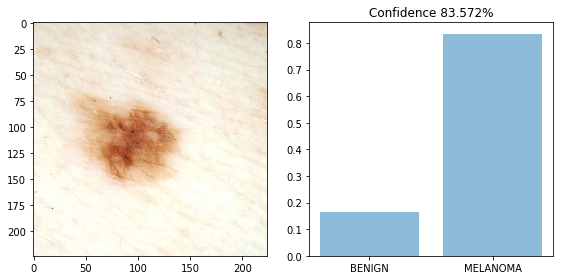

In [55]:
def test_adversarial(img, label):
    reset_graph()
    data_params = create_hyper_params()
    g2 = build_graph(data_params)
    best_params = load_obj(BEST_PARAMS_PATH)
    with tf.Session(graph=g2) as sess:
        saver, init_global, init_local = g2.get_collection("save_init")
        X, y_raw, training_op = g2.get_collection("main_ops")
        preds, y_true_cls, y_pred_cls, correct_prediction = g2.get_collection("preds")
        test_auc, test_auc_update, test_acc, test_acc_update, test_acc_reset_op = g2.get_collection("test_metrics")
        test_mean_loss, test_mean_loss_update, test_loss_reset_op = g2.get_collection("test_loss")
        logz = g2.get_collection("logits")[0]

        sess.run([init_global, init_local])

        restore_model_params(model_params=best_params, g=g2, sess=sess)
        sess.run([test_acc_reset_op, test_loss_reset_op])
        Xb, yb = np.expand_dims(img,0), np.expand_dims(label, 0)
        batch_accuracy, batch_loss, batch_auc = sess.run([test_acc_update, test_mean_loss_update, test_auc_update], 
                                                                  feed_dict={X:Xb,y_raw:[yb]})
        pred_value, true_cls_value, pred_cls_value = sess.run([preds, y_true_cls, y_pred_cls],
                                                              feed_dict={X:Xb,y_raw:[yb]})
        logits_val = sess.run([logz], feed_dict={X:Xb,y_raw:[yb]})[0]

        final_test_acc, final_test_loss, final_test_auc = sess.run([test_acc, test_mean_loss, test_auc])
        print("test auc: {:.3f}% acc: {:.3f}% loss: {:.5f}".format(final_test_auc*100, 
                                                                   final_test_acc*100,
                                                                   final_test_loss))
        print("true_class: {}\npred_class {}".format(true_cls_value, pred_cls_value))
        #print(pred_value[0][0])
        #confidence = pred_value[0][pred_idx][0]

        confidence = pred_value[0][0]
        display_figure_and_prob(img=img, conf=confidence, 
                                pred_malignant=pred_cls_value[0][0], gt_label=label, 
                                adv_bool=True)
        #display_figure_and_prob(adv.reshape(28, 28), pred_value[0])

    return pred_cls_value[0][0], confidence

a_pred_label, a_pred_confidence = test_adversarial(adv_out, cor_label[0])

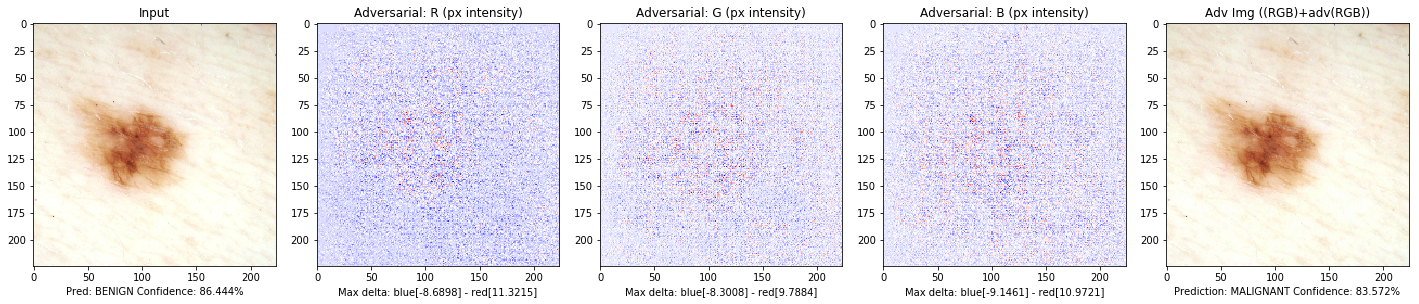

In [56]:
def plot_adv_array(img, adv, pred_label, pred_confidence, 
                   a_pred_label, a_pred_confidence):
    diff = adv - img
    r,g,b = np.split(diff, 3, axis=2)
    R = r.reshape(224,224)
    G = g.reshape(224,224)
    B = b.reshape(224,224)
    
    if pred_label:
        conf = pred_confidence
        pl = 'MELANOMA'
    else:
        conf = 100 - pred_confidence
        pl = 'BENIGN'
    if a_pred_label:
        a_conf = a_pred_confidence
        al = 'MALIGNANT'
    else:
        a_conf = 1 - a_pred_confidence
        al = 'BENIGN'
    
    
    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(nrows=1, ncols=5, figsize=(20, 4))
    ax1.imshow(img.astype(np.uint8), interpolation="nearest")
    #cmapx = plt.get_cmap('bwr')
    ax1.set_title("Input")
    ax1.set_xlabel("Pred: {} Confidence: {:.3f}%".format(pl, conf))
    ax2.imshow(diff.astype(np.uint8), interpolation="nearest")
    
    # TODO: THIS VISUALIZATION IS POOR
    # converting to uint8 is likely not the way to appoach this
    # likely will want to grab each channel, which may be interesting in iteself
    ax2.set_title("Adversarial: R (px intensity)")
    ax2.imshow(R, cmap=plt.get_cmap('bwr'), interpolation="nearest")
    ax2.set_xlabel("Max delta: blue[{:.4f}] - red[{:.4f}]".format(np.min(R), np.max(R)))
    
    ax3.set_title("Adversarial: G (px intensity)")
    ax3.imshow(G, cmap=plt.get_cmap('bwr'), interpolation="nearest")
    ax3.set_xlabel("Max delta: blue[{:.4f}] - red[{:.4f}]".format(np.min(G), np.max(G)))
    
    ax4.set_title("Adversarial: B (px intensity)")
    ax4.imshow(B, cmap=plt.get_cmap('bwr'), interpolation="nearest")
    ax4.set_xlabel("Max delta: blue[{:.4f}] - red[{:.4f}]".format(np.min(B), np.max(B)))

    ax5.imshow(adv.astype(np.uint8), interpolation="nearest")
    ax5.set_title("Adv Img ((RGB)+adv(RGB))")
    ax5.set_xlabel("Prediction: {} Confidence: {:.3f}%".format(al, a_conf*100))
    
    plt.grid('off')
    plt.tight_layout()
    name = "./output_images/adv_array_" + al + "_to_" + pl +"_adv.png"
    plt.savefig(name, bbox_inches='tight', pad_inches=0, frameon=False)
    plt.show()
#print(pred_confidence)
plot_adv_array(the_image, adv_out, pred_label[0], pred_confidence, a_pred_label, a_pred_confidence)

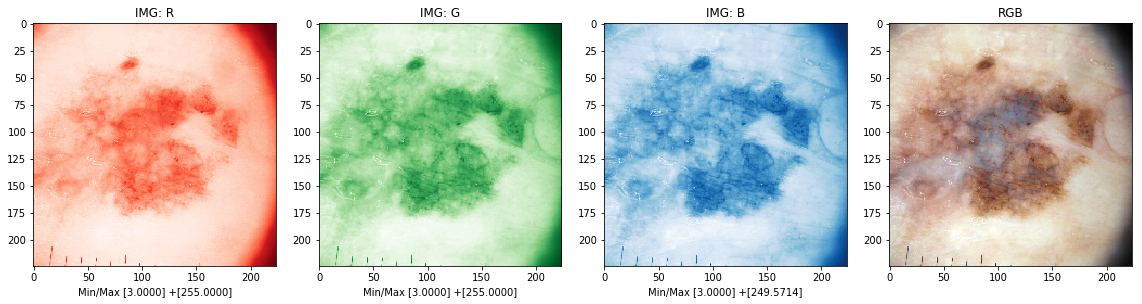

In [71]:
diff = adv_out - the_image
r,g,b = np.split(the_image, 3, axis=2)
R = r.reshape(224,224)
G = g.reshape(224,224)
B = b.reshape(224,224)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=4, figsize=(16, 4))


ax1.set_title("IMG: R")
ax1.imshow(R.astype(np.uint8), cmap=plt.cm.Reds_r, interpolation="nearest")
ax1.set_xlabel("Min/Max [{:.4f}] +[{:.4f}]".format(np.min(R), np.max(R)))

ax2.set_title("IMG: G")
ax2.imshow(G.astype(np.uint8), cmap=plt.cm.Greens_r, interpolation="nearest")
ax2.set_xlabel("Min/Max [{:.4f}] +[{:.4f}]".format(np.min(G), np.max(G)))

ax3.set_title("IMG: B")
ax3.imshow(B.astype(np.uint8), cmap=plt.cm.Blues_r, interpolation="nearest")
ax3.set_xlabel("Min/Max [{:.4f}] +[{:.4f}]".format(np.min(B), np.max(B)))

ax4.set_title("RGB")
ax4.imshow(the_image.astype(np.uint8), interpolation="nearest")
plt.grid('off')
plt.tight_layout()
plt.show()

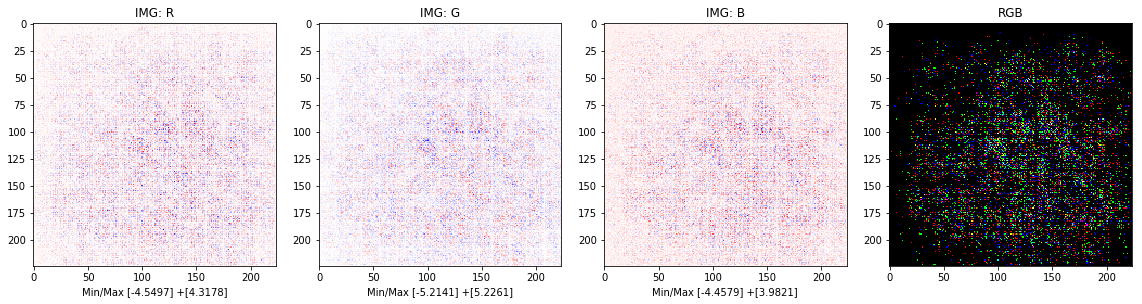

In [76]:
diff = adv_out - the_image
r,g,b = np.split(diff, 3, axis=2)
R = r.reshape(224,224)
G = g.reshape(224,224)
B = b.reshape(224,224)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=4, figsize=(16, 4))


ax1.set_title("IMG: R")
ax1.imshow(R, cmap=plt.get_cmap('bwr'), interpolation="nearest")
ax1.set_xlabel("Min/Max [{:.4f}] +[{:.4f}]".format(np.min(R), np.max(R)))

ax2.set_title("IMG: G")
ax2.imshow(G, cmap=plt.get_cmap('bwr'), interpolation="nearest")
ax2.set_xlabel("Min/Max [{:.4f}] +[{:.4f}]".format(np.min(G), np.max(G)))

ax3.set_title("IMG: B")
ax3.imshow(B, cmap=plt.get_cmap('bwr'), interpolation="nearest")
ax3.set_xlabel("Min/Max [{:.4f}] +[{:.4f}]".format(np.min(B), np.max(B)))

ax4.set_title("RGB")
ax4.imshow(diff.astype(np.uint8), cmap=plt.cm.gray, interpolation="nearest")
plt.grid('off')
plt.tight_layout()
plt.show()

## TODO:
### Top priority
1. Are the channels correct (RGB) - I don't have any reason to believe they're not, but I need to check
1. ~~why are the values [-3,255]? - this is strange to me~~ - formatting error on my part
1. I need the label index for each image - (will need to review dataset prep)
1. ~~why am I seeing different loss scores for each test run? this shouldn't happen~~ - this was related to the shuffle
### Future
1. Look into conv intermediate between variable and assignment 224x224x1 > [conv] > 224x224x3
1. I'd like to run some numbers on what channels+to what degree each channel is being manipulated to produce class _n_